In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, SpatialDropout2D, Input, MaxPool2D, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import vgg16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import Dataset, AUTOTUNE
import tensorflow.strings
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

from glob import glob
from pathlib import Path
import os

In [3]:
#loading data
PATH_TO_TRAINING = r'../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/'
PATH_TO_TRAINING_TENSOR = tf.Variable(PATH_TO_TRAINING)

TRAIN_GLAUCOMA_IMAGES = np.array(glob(os.path.join(PATH_TO_TRAINING, 'Images/GLAUCOMA/*')))
TRAIN_NORMAL_IMAGES = np.array(glob(os.path.join(PATH_TO_TRAINING, 'Images/NORMAL/*')))

TRAIN_GLAUCOMA_GT = np.array(glob(PATH_TO_TRAINING + '/GT/GALUCOMA/*'))
TRAIN_NORMAL_GT = np.array(glob(PATH_TO_TRAINING + '/GT/NORMAL/*'))

PATH_TO_TEST = r'../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test'
TEST_GLAUCOMA_IMAGES = np.array(glob(os.path.join(PATH_TO_TEST, 'Images/glaucoma/*')))
TEST_NORMAL_IMAGES = np.array(glob(os.path.join(PATH_TO_TEST, 'Images/normal/*')))

SEED = 2
EPSILON = 10 ** -4
STATELESS_RNG= tf.random.Generator.from_seed(SEED, alg='philox')
IMAGE_SIZE = (224, 224)
CHANNELS = 3
SHUFFLE_BUFFER = len(TRAIN_NORMAL_IMAGES) + len(TRAIN_GLAUCOMA_IMAGES)
BATCH_SIZE = SHUFFLE_BUFFER // 2
early_stopping = EarlyStopping(monitor = 'val_loss', restore_best_weights = True, patience = 5)


In [4]:
Path(TRAIN_GLAUCOMA_IMAGES[0]).stem
TEST_GLAUCOMA_IMAGES

array(['../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_054.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_048.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_071.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_006.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_079.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_003.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_083.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/T

In [5]:
#loading images and masks
def load_image_and_gt(path, test = False):
    print(path)
    
    filename = Path(path).stem
    if test:
        path_to_OD_softmap = os.path.join(PATH_TO_TEST, 'Test_GT', filename, 'SoftMap', filename + '_ODsegSoftmap.png')    
    else:
        path_to_OD_softmap = os.path.join(PATH_TO_TRAINING, 'GT', filename, 'SoftMap', filename + '_ODsegSoftmap.png')
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image)
    od = tf.io.read_file(path_to_OD_softmap)
    od = tf.io.decode_png(od)
    return image, od

def show_image_with_masks(image, od, ax, index, label): #, cup
    '''
    Plots the real world image
    And the two masks
    Also shows the image after
    being masked with each mask
    Requires len(ax) >= 5
    '''
    ax[3* index].imshow(image)
    ax[3* index].set_title(label)
    ax[3* index + 1].imshow(od)
    ax[3* index + 1].set_title('Optical Disk Mask')
    ax[3* index + 2].imshow(od * image)
    ax[3* index + 2].set_title('Image with OD Mask')
    
def load_image_with_masks(path, dice = False, test = False):
    
    filename = tf.strings.split(path, sep = '.')[-2]
    filename = tf.strings.split(filename, sep = '/')[-1]
    directory_path = tf.strings.split(path, sep = 'Images')[0]
    if test:
        softmap_path = tf.strings.join([directory_path, 'Test_GT/', filename, '/SoftMap/'])
    else:
        softmap_path = tf.strings.join([directory_path, 'GT/', filename, '/SoftMap/'])
    od_path = tf.strings.join([softmap_path, filename, '_ODsegSoftmap.png'])
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0
    
    od = tf.io.read_file(od_path)
    od = tf.io.decode_png(od, channels = 1)
    od = tf.image.resize(od, IMAGE_SIZE)
    od = od / 255.0
    if dice:
        od = tf.where(od >= 0.5, 1.0, 0.0)
    
    return {'image' : image}, {'od' : od}

def augment_images(image, od, single_target = False):
    
    seeds = STATELESS_RNG.make_seeds(2)[0], STATELESS_RNG.make_seeds(2)[0]
    
    def augment(img, seeds):
        
        img = tf.image.stateless_random_flip_left_right(img, seeds[0])
        img = tf.image.stateless_random_flip_up_down(img, seeds[1])
        img = tf.image.resize_with_crop_or_pad(img, IMAGE_SIZE[0] + 20, IMAGE_SIZE[1] + 20)
        img = tf.image.stateless_random_crop(img, size = (*IMAGE_SIZE, img.shape[2]), seed = seeds[0])
        
        return img
    
    image = augment(image, seeds)
    od = augment(od, seeds)
    #cup = augment(cup, seeds)
    
    if single_target:
        return image, od
    return {'image' : image}, {'od' : od} #, 'cup' : cup
    

../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/NORMAL/drishtiGS_042.png


TensorShape([1750, 2050, 3])

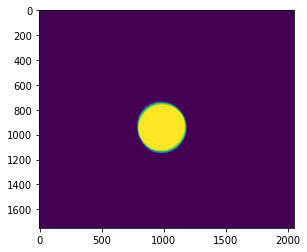

In [6]:
image, od= load_image_and_gt(TRAIN_NORMAL_IMAGES[0]) #, cup 
plt.imshow(od)
image.shape

../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/NORMAL/drishtiGS_036.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/NORMAL/drishtiGS_047.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_045.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_058.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_022.png


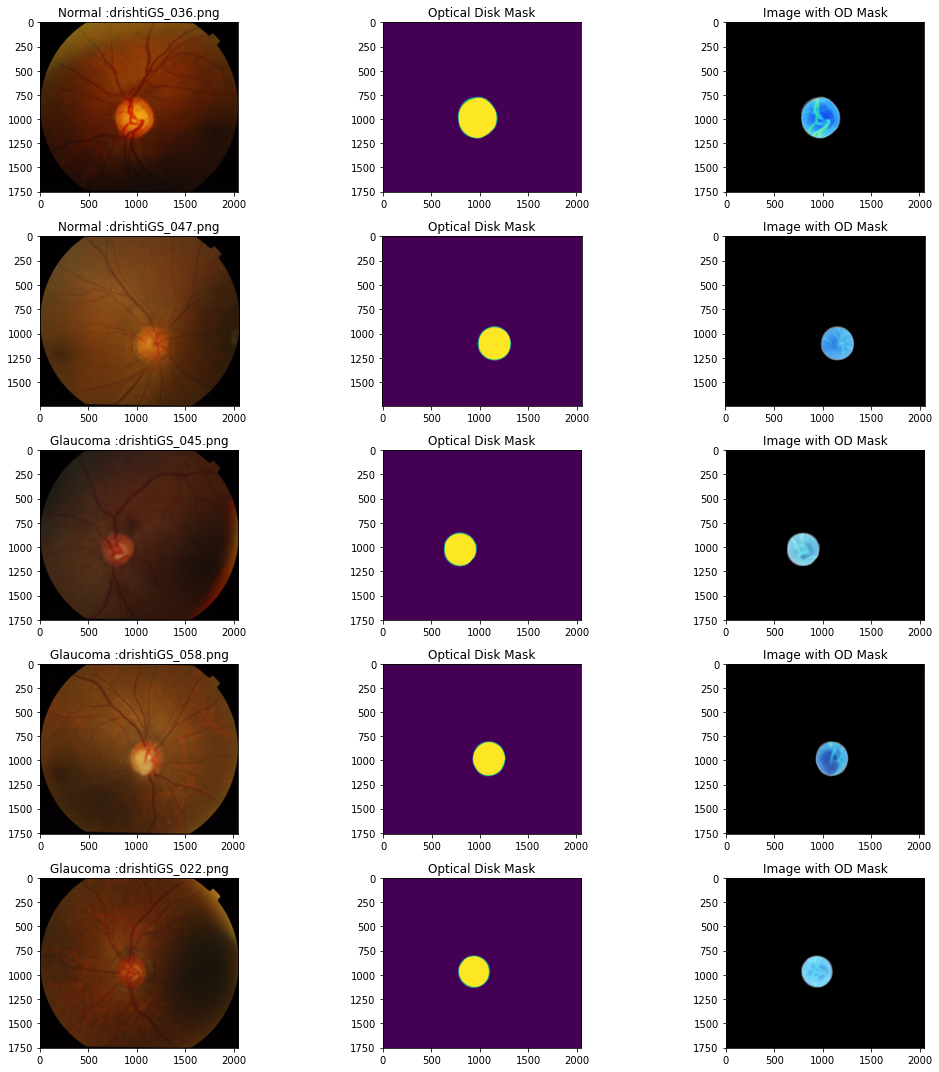

In [7]:
#display sample images
rows = 5
cols = 3
fig, axes = plt.subplots(rows, cols, figsize = (15, 15))
axes = axes.flatten()

normal_images = np.random.choice(TRAIN_NORMAL_IMAGES, rows // 2)
glaucoma_images = np.random.choice(TRAIN_GLAUCOMA_IMAGES, rows - (rows // 2))

for idx, file in enumerate(normal_images):
    image, od= load_image_and_gt(file) #, cup 
    show_image_with_masks(image, od, axes, index = idx, label = 'Normal :' + os.path.basename(file))
    
for idx, file in enumerate(glaucoma_images):
    image, od= load_image_and_gt(file) #, cup 
    show_image_with_masks(image, od, axes, index = idx + rows // 2, label = 'Glaucoma :' + os.path.basename(file)) 

plt.tight_layout()

In [8]:
def get_avgboundary(file):
    image = tf.io.read_file(file)
    image = tf.io.decode_png(image)
    
    od_mask = np.zeros(shape = (image.shape[0], image.shape[1]))
    center_mask = np.zeros(shape = (image.shape[0], image.shape[1]))
    
    filename = Path(file).stem
    boundary_path = os.path.join(PATH_TO_TRAINING, 'GT', filename, 'AvgBoundary')
    od_file = os.path.join(boundary_path, filename + '_ODAvgBoundary.txt')
    center_file = os.path.join(boundary_path, filename + '_diskCenter.txt')
    
    count = 0
    with open(od_file) as of:
        for line in of:
            a, b = line.split()
            a = int(a)
            b = int(b)
            od_mask[a, b] = 255
        
    with open(center_file) as ctrf:
        for line in ctrf:
            a, b = line.split()
            a = int(a)
            b = int(b)
            center_mask[a, b] = 255
    return od_mask.reshape(image.shape[0], image.shape[1], 1), \
center_mask.reshape(image.shape[0], image.shape[1], 1) #cup_mask.reshape(image.shape[0], image.shape[1], 1)
    

In [9]:
glaucoma_avgboundary_test = TRAIN_GLAUCOMA_IMAGES[3]

od_mask, center_mask = get_avgboundary(glaucoma_avgboundary_test) # cup_mask,
image, od= load_image_and_gt(glaucoma_avgboundary_test) #, cup 

../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_004.png


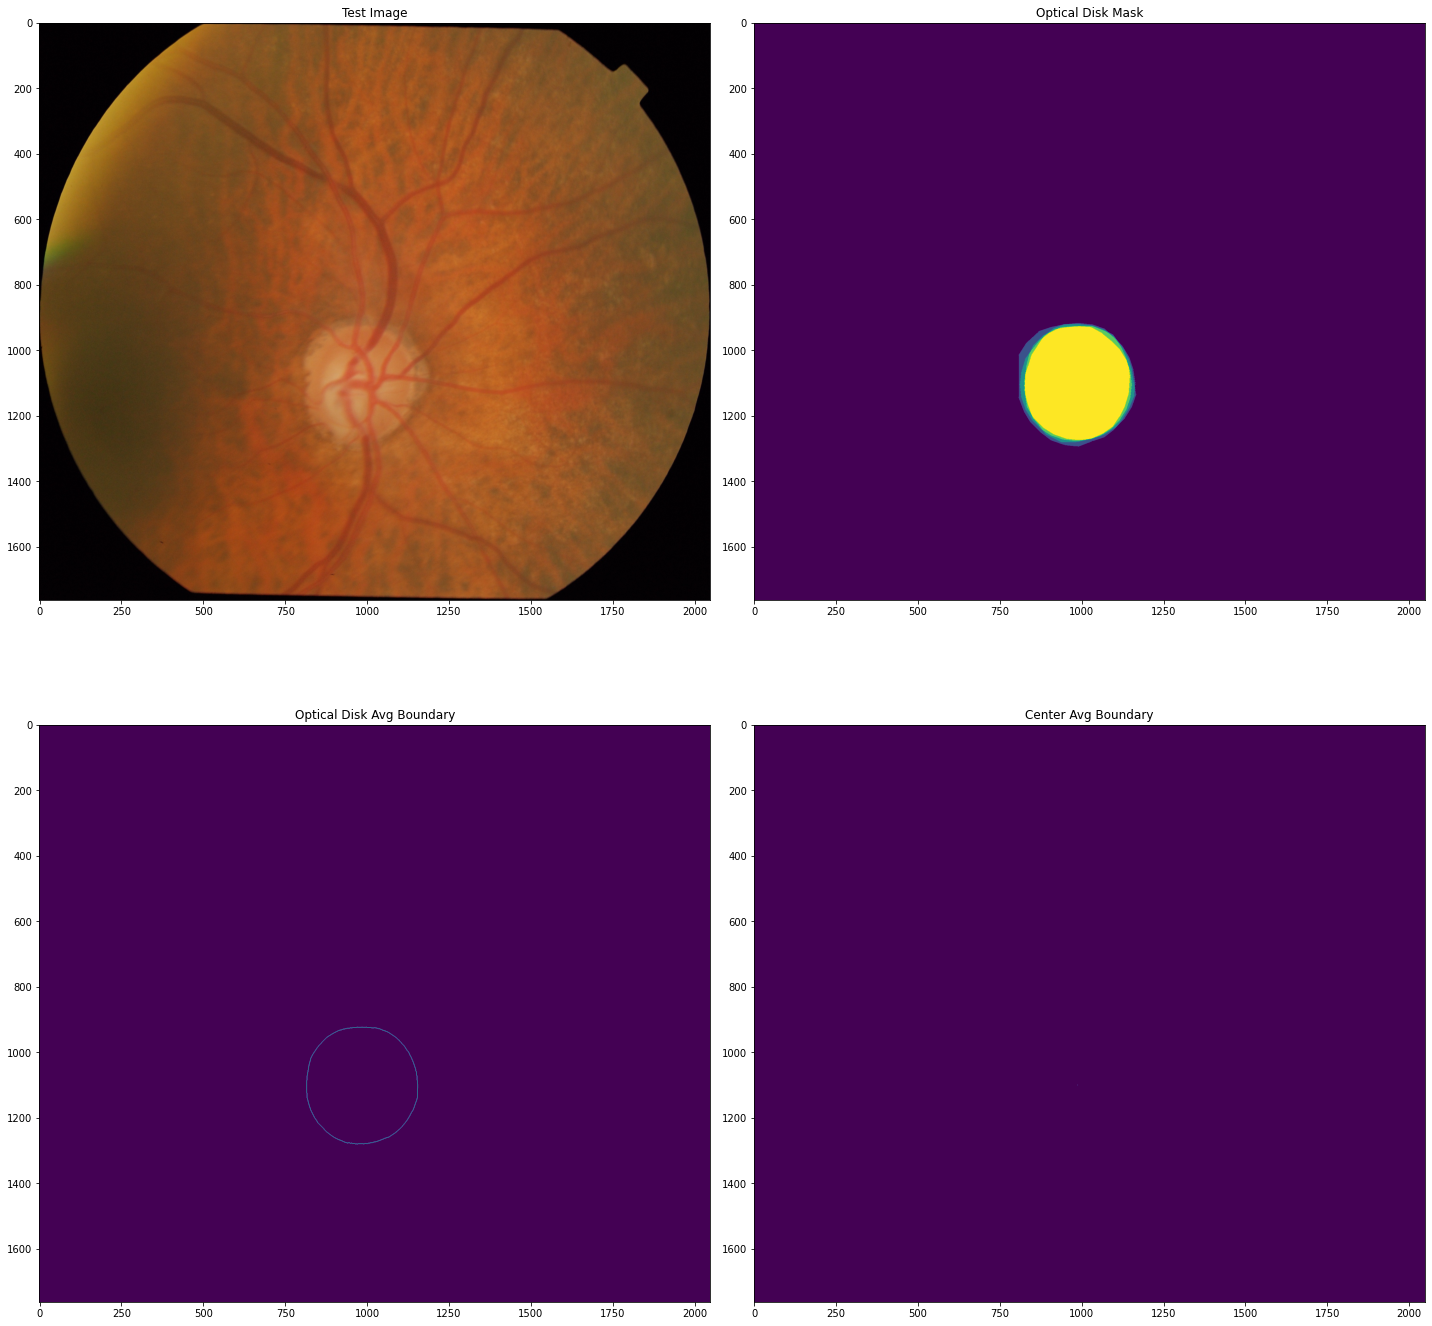

In [10]:
fig, axes = plt.subplots(2, 2, figsize = (20, 20))
axes = axes.flatten()

axes[0].imshow(image)
axes[0].set_title('Test Image')
axes[1].imshow(od)
axes[1].set_title('Optical Disk Mask')
axes[2].imshow(od_mask)
axes[2].set_title('Optical Disk Avg Boundary')
#axes[3].imshow(cup)
#axes[3].set_title('Cup Mask')
#axes[4].imshow(cup_mask)
#axes[4].set_title('Cup Avg Boundary')
axes[3].imshow(center_mask)
axes[3].set_title('Center Avg Boundary')
plt.tight_layout()

In [11]:
#splitting data
train_images = np.concatenate([TRAIN_NORMAL_IMAGES, TRAIN_GLAUCOMA_IMAGES])
test_images = np.concatenate([TEST_NORMAL_IMAGES, TEST_GLAUCOMA_IMAGES])

train_ds_dice = Dataset.from_tensor_slices(train_images)\
    .shuffle(buffer_size = SHUFFLE_BUFFER)\
    .map(lambda x: load_image_with_masks(x, dice = True), num_parallel_calls = AUTOTUNE)\
    .map(lambda image, targets: augment_images(image['image'], targets['od']))\
    .batch(batch_size = BATCH_SIZE)\
    .prefetch(1)\
    .cache()

train_ds_no_dice = Dataset.from_tensor_slices(train_images)\
    .shuffle(buffer_size = SHUFFLE_BUFFER)\
    .map(lambda x: load_image_with_masks(x, dice = False), num_parallel_calls = AUTOTUNE)\
    .map(lambda image, targets: augment_images(image['image'], targets['od']))\
    .batch(batch_size = BATCH_SIZE)\
    .prefetch(1)\
    .cache()

test_ds_dice = Dataset.from_tensor_slices(test_images)\
    .map(lambda x: load_image_with_masks(x, dice = True, test = True), num_parallel_calls = AUTOTUNE)\
    .batch(batch_size = BATCH_SIZE)

test_ds_no_dice = Dataset.from_tensor_slices(test_images)\
    .map(lambda x: load_image_with_masks(x, dice = False, test = True), num_parallel_calls = AUTOTUNE)\
    .batch(batch_size = BATCH_SIZE)

In [12]:
def upsampling_block(inp, skips, filters, kernels, rates):
    
    activation = 'relu'
    x = inp  
    for f, kernel, skip, rate in zip(filters, kernels, skips, rates):
        x = UpSampling2D()(x)
        x = Conv2D(filters = f, kernel_size = kernel, strides = 1, activation = activation, padding = 'same')(x)
        x = concatenate([x, skip])
        x = BatchNormalization()(x)
        x = SpatialDropout2D(rate = rate)(x)
    return x

def conv_block(inp, filters, kernels, strides, rates):
    
    activation = 'relu'
    x = inp
    skips = []
    for f, kernel, stride, rate in zip(filters, kernels, strides, rates):
        if stride == 2:
            skips.append(skip)
            x = MaxPool2D()(x)
            x = Conv2D(filters = f, kernel_size = kernel, strides = 1, activation = activation, padding = 'same')(x)
            skip = x
        else:
            x = Conv2D(filters = f, kernel_size = kernel, strides = 1, activation = activation, padding = 'same')(x)
            skip = x
        
        x = BatchNormalization()(x)
        x = SpatialDropout2D(rate = rate)(x)
    
    return skips, x

In [13]:
def res_unet(conv_filters, conv_kernels, conv_strides, conv_rates, up_filters, up_kernels, up_rates):
    inp = Input(shape = (*IMAGE_SIZE, 3), name = 'image')
    x = inp
    
    skips, x = conv_block(x, conv_filters, conv_kernels, conv_strides, conv_rates)
    
    skips = skips[::-1]
    
    od = upsampling_block(x, skips, up_filters, up_kernels, up_rates)
    od = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = 'same', activation = 'sigmoid', name = 'od')(od)
       
    return Model(inputs = inp, outputs = [od]) #, cup

In [14]:
def dice(y, y_pred):
    epsilon = EPSILON
    numerator = 2 * tf.reduce_sum(y * y_pred, axis = [1, 2])
    denominator = tf.reduce_sum(y + y_pred, axis = [1, 2])
    dice = tf.reduce_mean((numerator + epsilon)/(denominator + epsilon))
    return 1 - dice

In [15]:
conv_filters = [8, 16, 32, 64]
conv_kernels = [3, 3, 3, 3]
conv_strides = [1, 2, 2, 2]
conv_rates = [0.8, 0.8, 0.8, 0.8]

upsampling_filters = [32, 16, 8, 8]
upsampling_kernels = [3, 3, 3, 3]
upsampling_rates = [0.5, 0.5, 0.5, 0.5]

mod1 = res_unet(conv_filters, conv_kernels, conv_strides, conv_rates, upsampling_filters, upsampling_kernels, upsampling_rates)
mod1.compile(optimizer = 'Adam', loss = {'od' : dice}, metrics = ['accuracy'])

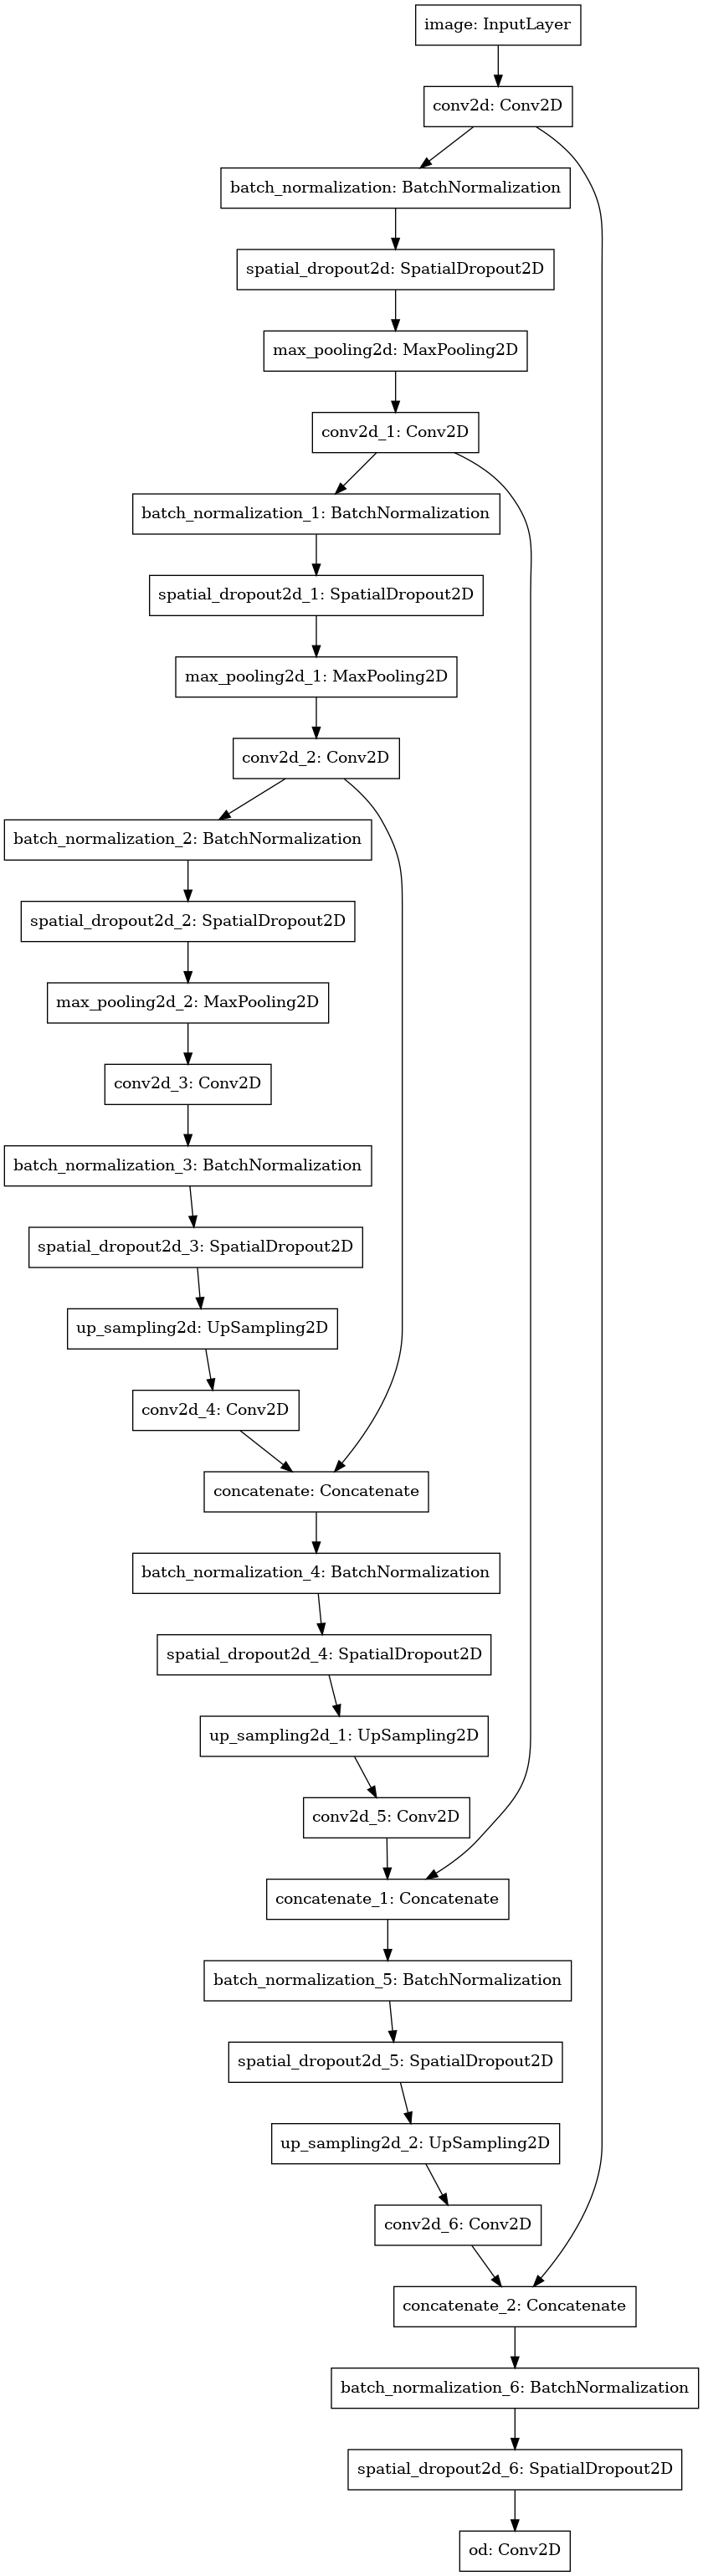

In [16]:
plot_model(mod1)

In [17]:
hist1 = mod1.fit(train_ds_dice, validation_data = test_ds_dice, callbacks = [early_stopping], epochs = 300)

Epoch 1/300
2/2 [==============================] - 19s 6s/step - loss: 0.9757 - accuracy: 0.4231 - val_loss: 0.9524 - val_accuracy: 0.8423
Epoch 2/300
2/2 [==============================] - 4s 3s/step - loss: 0.9772 - accuracy: 0.4592 - val_loss: 0.9517 - val_accuracy: 0.8285
Epoch 3/300
2/2 [==============================] - 4s 3s/step - loss: 0.9718 - accuracy: 0.4664 - val_loss: 0.9509 - val_accuracy: 0.8237
Epoch 4/300
2/2 [==============================] - 4s 4s/step - loss: 0.9713 - accuracy: 0.4450 - val_loss: 0.9499 - val_accuracy: 0.8219
Epoch 5/300
2/2 [==============================] - 4s 3s/step - loss: 0.9673 - accuracy: 0.4452 - val_loss: 0.9487 - val_accuracy: 0.8381
Epoch 6/300
2/2 [==============================] - 4s 4s/step - loss: 0.9711 - accuracy: 0.4532 - val_loss: 0.9475 - val_accuracy: 0.9038
Epoch 7/300
2/2 [==============================] - 4s 3s/step - loss: 0.9566 - accuracy: 0.4636 - val_loss: 0.9463 - val_accuracy: 0.9294
Epoch 8/300
2/2 [================

In [18]:
mod1.save('Model1.h5')

In [19]:
!cp /kaggle/input/modelfile/Model1.h5 /kaggle/working


In [20]:
mod1 = load_model('Model1.h5', custom_objects={"dice":dice})

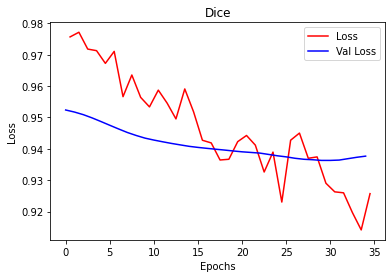

In [21]:
def plot_loss(epochs, hist, loss):
    plt.plot(epochs + .5, hist.history['loss'], 'r', label = 'Loss')
    plt.plot(epochs, hist.history['val_loss'], 'b', label = 'Val Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(loss)


epochs1 = np.arange(0, len(hist1.history['loss']))
plot_loss(epochs1, hist1, 'Dice')

In [22]:
to_predict = Dataset.from_tensor_slices(test_images)\
    .map(lambda x: load_image_with_masks(x, dice = True, test = True), num_parallel_calls = AUTOTUNE)\
    .map(lambda image, targets: image['image'])\
    .batch(batch_size = BATCH_SIZE)


predict1 = mod1.predict(to_predict)

In [23]:
print(predict1.shape)

(51, 224, 224, 1)


In [24]:
test = next(iter(predict1))
test.shape

(224, 224, 1)

In [25]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection =sum(y_true * y_pred)
  union = sum(y_true+y_pred)
  iou = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return iou

In [26]:
def plt_preds(ds, preds, super_title, binarizer_threshold = 0.5):
    ds = next(iter(ds))
    image, targets = ds
    image = image['image']
    od = targets['od']
    rows = 5
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize = (20, 20))
    axes = axes.flatten()
    for i in range(rows):
        
        axes[cols * i].imshow(image[i])
        axes[cols * i].set_title('Original Image')
        axes[cols * i + 1].imshow(od[i])
        axes[cols * i + 1].set_title('Original OD Mask')
        axes[cols * i + 2].imshow(preds[i])
        axes[cols * i + 2].set_title('Predicted OD Mask')
        Binary=np.where(preds[i] > binarizer_threshold, 1, 0)
        axes[cols * i + 3].imshow(Binary)
        axes[cols * i + 3].set_title('Binarized OD Mask')
        final=image[i]*Binary
        print("Final Image:",final.shape)
        axes[cols * i + 4].imshow(final)
        axes[cols * i + 4].set_title('Segmented Image')
        print(iou_coef(od[i],Binary))
    plt.suptitle(super_title)

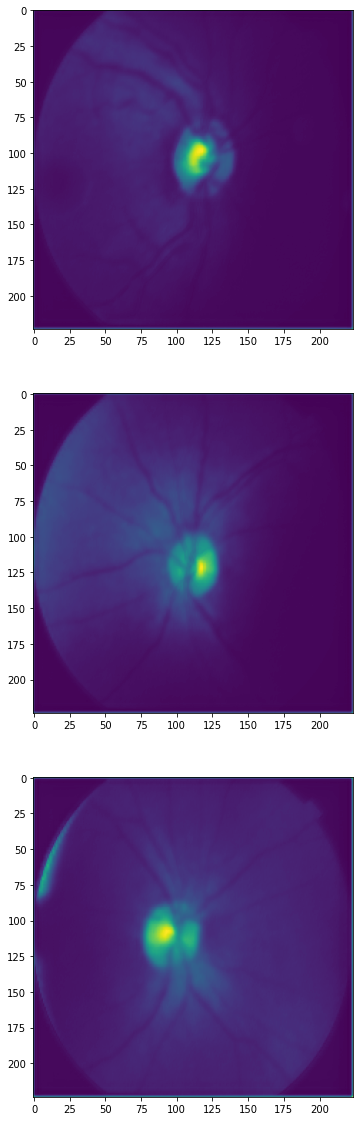

In [27]:
fig, axes = plt.subplots(3, 1, figsize = (20, 20))
axes = axes.flatten()
axes[0].imshow(predict1[0])
axes[1].imshow(predict1[1])
axes[2].imshow(predict1[2])


Final Image: (224, 224, 3)
tf.Tensor([0.8802753], shape=(1,), dtype=float32)
Final Image: (224, 224, 3)
tf.Tensor([0.95999956], shape=(1,), dtype=float32)
Final Image: (224, 224, 3)
tf.Tensor([0.8832845], shape=(1,), dtype=float32)
Final Image: (224, 224, 3)
tf.Tensor([0.7260928], shape=(1,), dtype=float32)
Final Image: (224, 224, 3)
tf.Tensor([0.6803704], shape=(1,), dtype=float32)


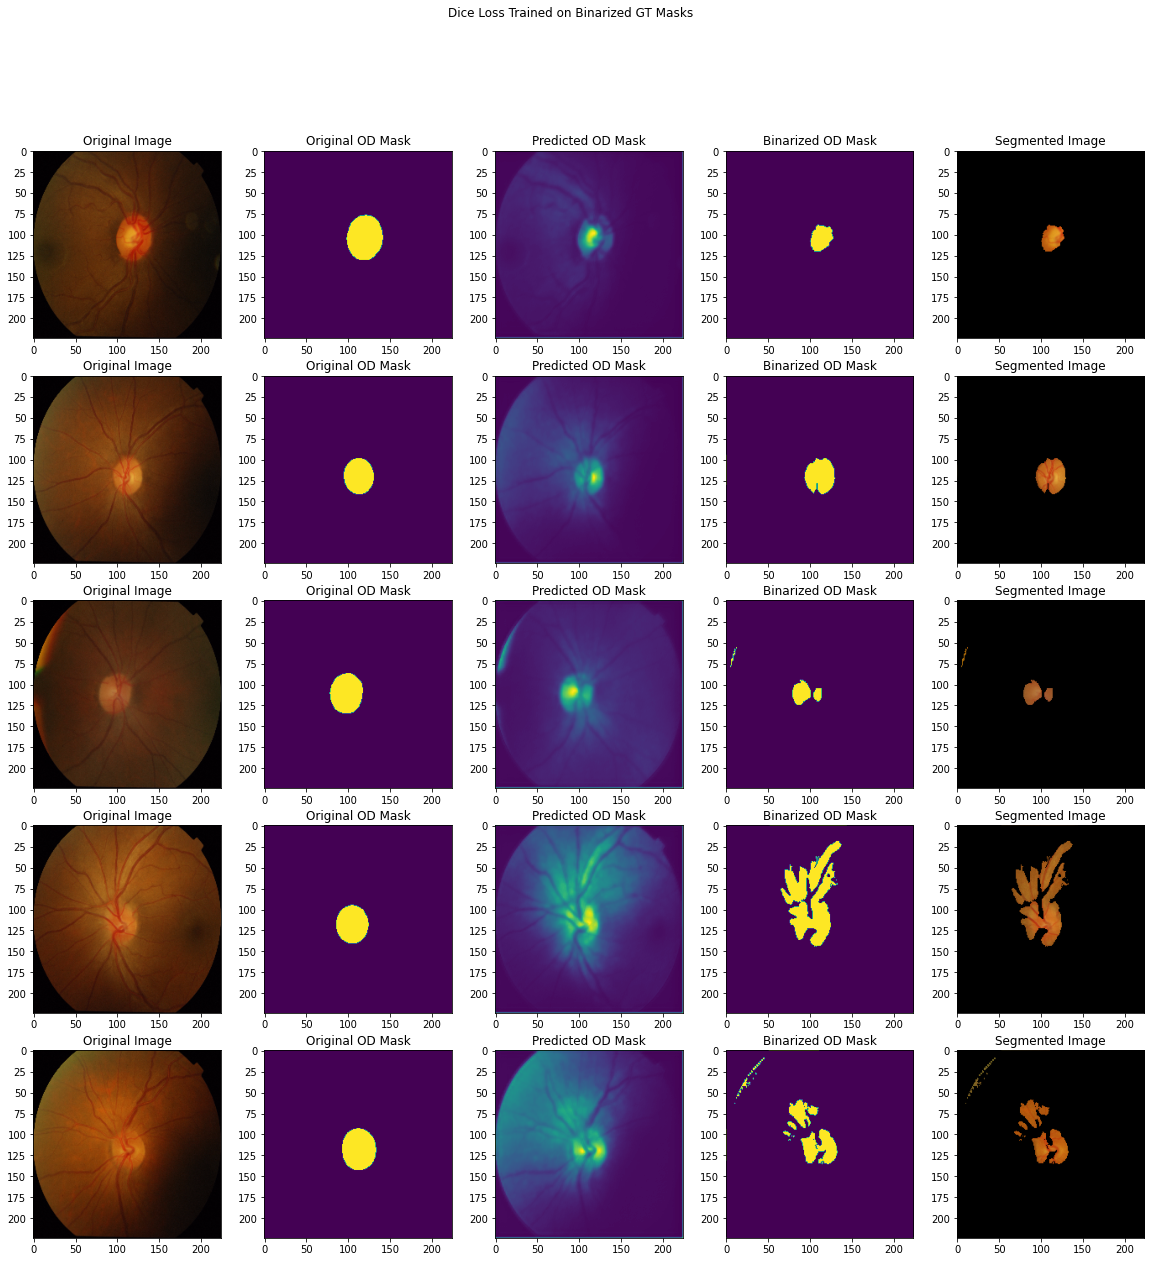

In [28]:
#display images after segmentation
plt_preds(test_ds_dice, predict1, super_title = 'Dice Loss Trained on Binarized GT Masks', binarizer_threshold = 0.16)

In [29]:
#calculating accuracy
accuracy=0
ds = next(iter(test_ds_dice))
image, targets = ds
image = image['image']
print(image.shape)
od = targets['od']
print(od.shape)
Binary=np.where(predict1> 0.1975, 1, 0)
for i in range(len(od)):
    accuracy+=iou_coef(od[i],Binary[i])[0]
print("Accuracy:",accuracy/25)

(25, 224, 224, 3)
(25, 224, 224, 1)
Accuracy: tf.Tensor(0.86306196, shape=(), dtype=float32)


<h1>--------------------------------------------------------------------------------------------------</h1>